In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install xlrd==2.0.1

In [3]:
# read the data set
df = pd.read_excel("D:\\求职 - us\\公司\\Aarki\\take home assignment\\assignment.xls", sheet_name="Sheet1",  engine="xlrd")

In [4]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   LeadCreated                  3021 non-null   datetime64[ns]
 1   FirstName                    3021 non-null   object        
 2   Email                        3021 non-null   object        
 3   VendorLeadID                 3013 non-null   object        
 4   CallStatus                   881 non-null    object        
 5   WidgetName                   3021 non-null   object        
 6   PublisherZoneName            3021 non-null   object        
 7   PublisherCampaignName        3021 non-null   object        
 8   AddressScore                 1171 non-null   float64       
 9   PhoneScore                   1393 non-null   float64       
 10  AdvertiserCampaignName       3021 non-null   object        
 11  State                        3021 non-null 

# Lead Quality

In [5]:
df['LeadCreated'] = pd.to_datetime(df['LeadCreated'])

In [6]:
callstatus_count = df['CallStatus'].value_counts()
callstatus_types = df['CallStatus'].unique()
print("\n CallStatus types:")
print(callstatus_types)


 CallStatus types:
[nan 'Unable to contact - Bad Contact Information'
 "Contacted - Doesn't Qualify" 'Closed' 'EP Received' 'EP Confirmed'
 'Contacted - Invalid Profile' 'EP Sent']


In [7]:
lead_quality_mapping = {
    "Closed": 10,
    "EP Sent": 1, "EP Received": 5, "EP Confirmed": 7,
    "Unable to contact - Bad Contact Information": -10,
    "Contacted - Invalid Profile": -5, "Contacted - Doesn't Qualify": -1
}
df['LeadQuality'] = df['CallStatus'].map(lead_quality_mapping).fillna(0)


In [8]:

# Create categorical labels for positive, negative, and all leads
positive_leads = ["Closed", "EP Sent", "EP Received", "EP Confirmed"]
negative_leads = ["Unable to contact - Bad Contact Information", "Contacted - Invalid Profile", "Contacted - Doesn't Qualify"]

# Create categorical columns
df["PositiveLead"] = df[df["CallStatus"].isin(positive_leads)]['LeadQuality']
df["NegativeLead"] = df[df["CallStatus"].isin(negative_leads)]['LeadQuality']

# Aggregate by week
#df["YearMonth"] = df["LeadCreated"].dt.to_period("M").apply(lambda x: x.start_time)
df["Week"] = df["LeadCreated"].dt.to_period("W").apply(lambda x: x.start_time)
weekly_leads = df.groupby("Week")[["PositiveLead", "NegativeLead", "LeadQuality"]].sum().reset_index()


In [9]:
weekly_leads["WeekNumeric"] = np.arange(len(weekly_leads))

In [10]:
# fit linear trends for each category
positive_trend = np.polyfit(weekly_leads["WeekNumeric"], weekly_leads["PositiveLead"], 1)
negative_trend = np.polyfit(weekly_leads["WeekNumeric"], weekly_leads["NegativeLead"], 1)

lead_quality_trend = np.polyfit(weekly_leads["WeekNumeric"], weekly_leads["LeadQuality"], 1)

# Generate trendline values
positive_trend_line = np.polyval(positive_trend, weekly_leads["WeekNumeric"])
negative_trend_line = np.polyval(negative_trend, weekly_leads["WeekNumeric"])

lead_quality_trend_line = np.polyval(lead_quality_trend, weekly_leads["WeekNumeric"])


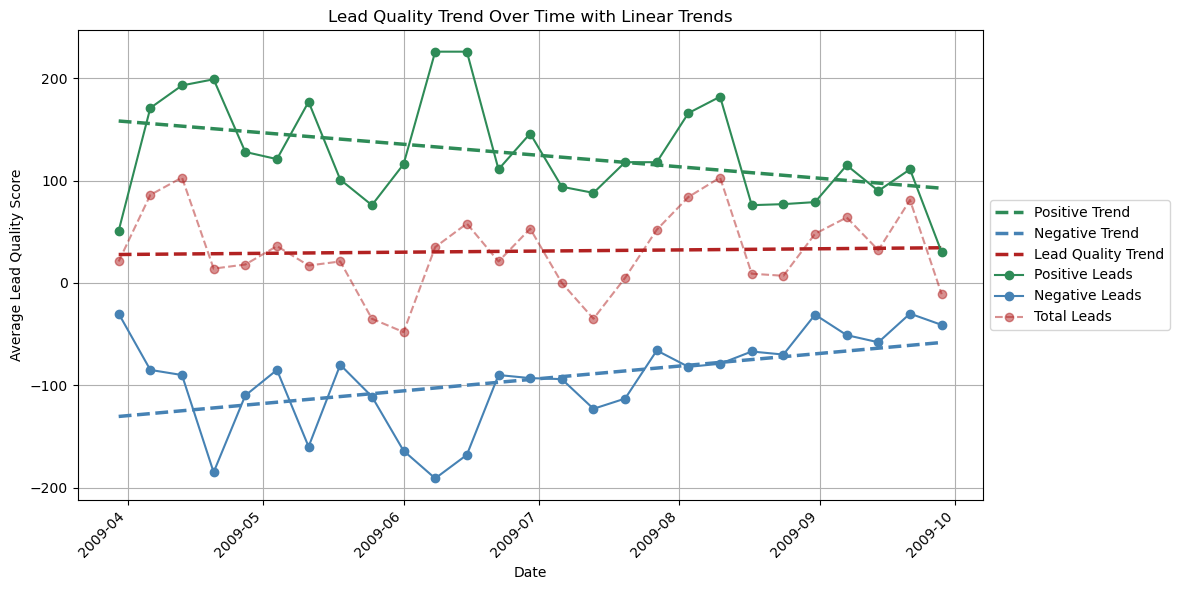

In [11]:
# Plot the bar chart
plt.figure(figsize = (14,6))
ax = plt.gca()

# trend lines
plt.plot(weekly_leads["Week"], positive_trend_line[:len(weekly_leads)], color="#2E8B57",linestyle="dashed", linewidth=2.5, label="Positive Trend") # positive for green
plt.plot(weekly_leads["Week"], negative_trend_line[:len(weekly_leads)], color="#4682B4", linestyle="dashed", linewidth=2.5, label="Negative Trend") # negative for blue
plt.plot(weekly_leads["Week"], lead_quality_trend_line[:len(weekly_leads)], color="#B22222", linestyle="dashed", linewidth=2.5, label="Lead Quality Trend") # total Lead for red

weekly_leads.plot(x="Week", y="PositiveLead", ax=ax, color="#2E8B57", linestyle="-", marker="o", label="Positive Leads")
weekly_leads.plot(x="Week", y="NegativeLead", ax=ax, color="#4682B4", linestyle="-", marker="o", label="Negative Leads")
weekly_leads.plot(x="Week", y="LeadQuality", ax=ax, color="#B22222", linestyle="--", marker="o", alpha=0.5, label="Total Leads")

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Average Lead Quality Score")
ax.set_title("Lead Quality Trend Over Time with Linear Trends")
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5)) 
plt.tight_layout(rect=[0, 0, 0.85, 1])  
# Show the plot
plt.show()



#### Q: Are we seeing any lead quality trends over time (improving, declining)?
A: Yes. Following is the lead quality trend by week. Under the score listed above, positive lead quality is declining while negative lead is improving. Resulting the average lead stedy.

In [12]:
# significance analysis

import statsmodels.api as sm # linear regression model OLS, sm.OLS(Y, X)
from scipy.stats import linregress 

Linear Regression Results: 
Slope: -2.5269
Intercept: 158.2566
p-value: 0.0451 (Statistically Significant: Yes)
R² Value: 0.1511 (Explains 15.11% of variation)
Standard Error: 1.1981


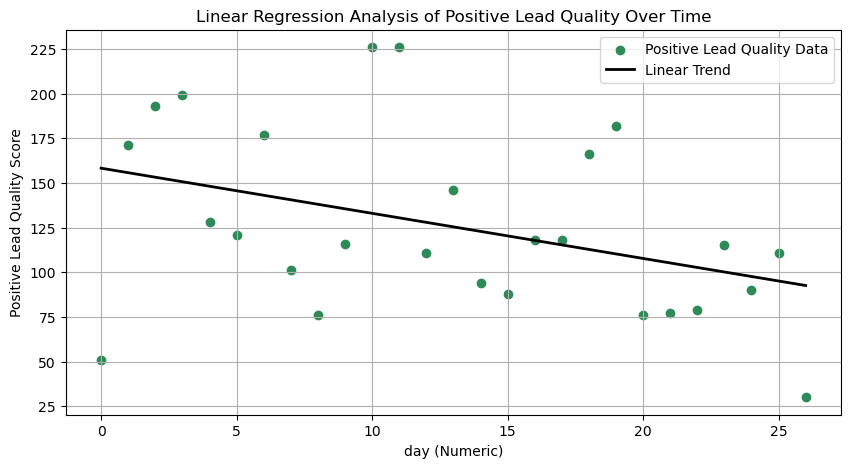

In [13]:
# Positivelead trend significance test
X = weekly_leads["WeekNumeric"] 
Y = weekly_leads["PositiveLead"]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

slope, intercept, r_value, p_value, std_err = linregress(weekly_leads["WeekNumeric"], weekly_leads["PositiveLead"])

print("Linear Regression Results: ")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"p-value: {p_value:.4f} (Statistically Significant: {'Yes' if p_value < 0.05 else 'No'})")
print(f"R² Value: {r_value**2:.4f} (Explains {r_value**2*100:.2f}% of variation)")
print(f"Standard Error: {std_err:.4f}")

plt.figure(figsize=(10, 5))
plt.scatter(weekly_leads["WeekNumeric"], weekly_leads["PositiveLead"], color="#2E8B57", label="Positive Lead Quality Data") # green for positive data
plt.plot(weekly_leads["WeekNumeric"], intercept + slope * weekly_leads["WeekNumeric"], color="black", linewidth=2, label="Linear Trend") # intercept for red
plt.xlabel("day (Numeric)")
plt.ylabel("Positive Lead Quality Score")
plt.title("Linear Regression Analysis of Positive Lead Quality Over Time")
plt.legend()
plt.grid(True)
plt.show()


Linear Regression Results:
Slope: 2.7802
Intercept: -130.4762
p-value: 0.0114 (Statistically Significant: Yes)
R² Value: 0.2297 (Explains 22.97% of variation)
Standard Error: 1.0184


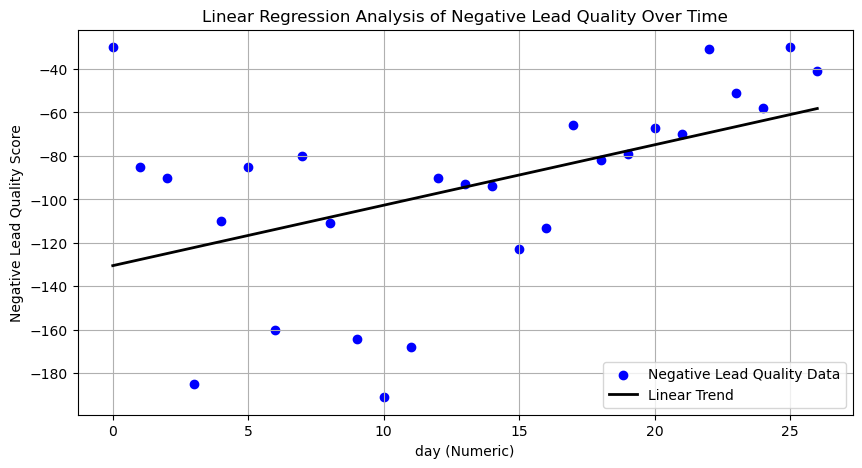

In [14]:
# Negativelead trend significance test
X = weekly_leads["WeekNumeric"]  # Independent variable (time)
Y = weekly_leads["NegativeLead"]  # Dependent variable (lead quality score)
X = sm.add_constant(X)  # Add intercept term
model = sm.OLS(Y, X).fit()

slope, intercept, r_value, p_value, std_err = linregress(weekly_leads["WeekNumeric"], weekly_leads["NegativeLead"])

print("Linear Regression Results:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"p-value: {p_value:.4f} (Statistically Significant: {'Yes' if p_value < 0.05 else 'No'})")
print(f"R² Value: {r_value**2:.4f} (Explains {r_value**2*100:.2f}% of variation)")
print(f"Standard Error: {std_err:.4f}")

plt.figure(figsize=(10, 5))
plt.scatter(weekly_leads["WeekNumeric"], weekly_leads["NegativeLead"], color="blue", label="Negative Lead Quality Data")
plt.plot(weekly_leads["WeekNumeric"], intercept + slope * weekly_leads["WeekNumeric"], color="black", linewidth=2, label="Linear Trend")
plt.xlabel("day (Numeric)")
plt.ylabel("Negative Lead Quality Score")
plt.title("Linear Regression Analysis of Negative Lead Quality Over Time")
plt.legend()
plt.grid(True)
plt.show()

Linear Regression Results:
Slope: 0.2534
Intercept: 27.7804
p-value: 0.8046 (Statistically Significant: No)
R² Value: 0.0025 (Explains 0.25% of variation)
Standard Error: 1.0132


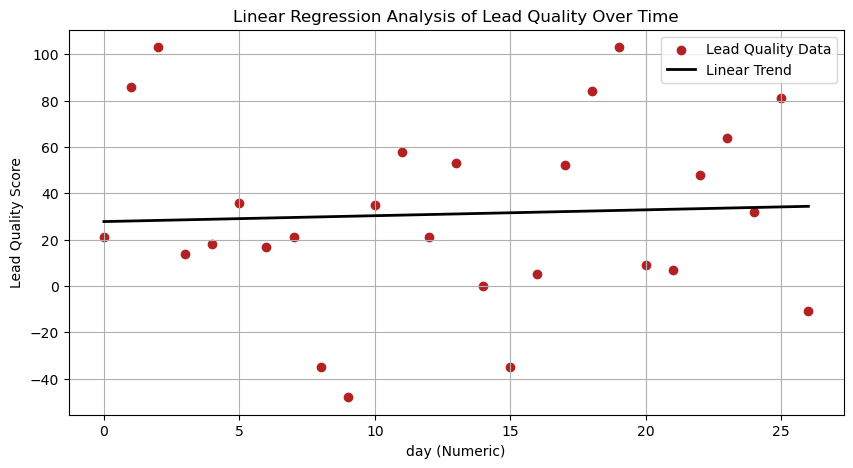

In [15]:
# Averagelead trend significance test
X = weekly_leads["WeekNumeric"]  # Independent variable (time)
Y = weekly_leads["LeadQuality"]  # Dependent variable (lead quality score)
X = sm.add_constant(X)  # Add intercept term
model = sm.OLS(Y, X).fit()

slope, intercept, r_value, p_value, std_err = linregress(weekly_leads["WeekNumeric"], weekly_leads["LeadQuality"])

print("Linear Regression Results:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"p-value: {p_value:.4f} (Statistically Significant: {'Yes' if p_value < 0.05 else 'No'})")
print(f"R² Value: {r_value**2:.4f} (Explains {r_value**2*100:.2f}% of variation)")
print(f"Standard Error: {std_err:.4f}")

plt.figure(figsize=(10, 5))
plt.scatter(weekly_leads["WeekNumeric"], weekly_leads["LeadQuality"], color="#B22222", label="Lead Quality Data")
plt.plot(weekly_leads["WeekNumeric"], intercept + slope * weekly_leads["WeekNumeric"], color="black", linewidth=2, label="Linear Trend")
plt.xlabel("day (Numeric)")
plt.ylabel("Lead Quality Score")
plt.title("Linear Regression Analysis of Lead Quality Over Time")
plt.legend()
plt.grid(True)
plt.show()

#### Q: Are they statistically significant?
A: Under the score listed above, for average lead quality trend, it is insignificant. However, positive lead trend and negative lead trend are statistically significant falling under 95% confident interval

# Drivers of Lead
    #### where the ads were shown;
    #### what kind of person filled out the ads;
    #### what kind of ads did they see

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   LeadCreated                  3021 non-null   datetime64[ns]
 1   FirstName                    3021 non-null   object        
 2   Email                        3021 non-null   object        
 3   VendorLeadID                 3013 non-null   object        
 4   CallStatus                   881 non-null    object        
 5   WidgetName                   3021 non-null   object        
 6   PublisherZoneName            3021 non-null   object        
 7   PublisherCampaignName        3021 non-null   object        
 8   AddressScore                 1171 non-null   float64       
 9   PhoneScore                   1393 non-null   float64       
 10  AdvertiserCampaignName       3021 non-null   object        
 11  State                        3021 non-null 

### Ads. source

In [17]:
# 1. what segments - where the ad was shown
# PublisherZoneName; PublisherCampaignName; Partner

# group by key segments and calculate average lead quality
segment_analysis = {}

## Leads source
segment_analysis["PublisherZoneName"] = df.groupby("PublisherZoneName")["LeadQuality"].mean()
segment_analysis["PublisherCampaignName"] = df.groupby("PublisherCampaignName")["LeadQuality"].mean()
segment_analysis["Partner"] = df.groupby("Partner")["LeadQuality"].mean()

# Display results
for key, df_segment in segment_analysis.items():
    print(f"\n=== Average Lead Quality by {key} ===")
    print(df_segment.sort_values(ascending = False))


=== Average Lead Quality by PublisherZoneName ===
PublisherZoneName
Top Right-300x250    0.583026
TopLeft-302252       0.247636
Name: LeadQuality, dtype: float64

=== Average Lead Quality by PublisherCampaignName ===
PublisherCampaignName
DebtReductionCallCenter    0.583026
DebtReductionInc           0.247636
Name: LeadQuality, dtype: float64

=== Average Lead Quality by Partner ===
Partner
Advertise.com    3.333333
AdKnowledge      0.976608
Call_Center      0.583026
google           0.430031
yahoo            0.262004
Google          -0.262911
Name: LeadQuality, dtype: float64


#### Key Insights
Top Right (300×250) performs significantly better than Top Left (302252).
Call center (leads created by people calling) performs significantly better than the leads that filled out the form online.
Placement of the ad affects lead quality, likely due to visibility and user engagement.

Advertise.com generates the highest quality leads (3.33), much higher than other sources.
Google (capitalized) performs poorly (-0.26), which could indicate low-quality or bot traffic.
Yahoo and Google drive lower-quality leads than AdKnowledge and Call Center.

#### Recommendations
Prioritize ad placements in "Top Right - 300×250".
Shift budget toward Advertise.com, as it provides the best leads.
Investigate Google (capitalized) traffic for low engagement.


### Customer Characteristics
(what kind of person filled out the ad)

In [18]:
# 2. what segments - what kind of person filled out the ad
# AddressScore; PhoneScore; DebtLevel; State

# group by key segments and calculate average lead quality
segment_analysis = {}

In [19]:
# User Characteristics
segment_analysis["AddressScore"] = df.groupby("AddressScore")["LeadQuality"].mean()
segment_analysis["PhoneScore"] = df.groupby("PhoneScore")["LeadQuality"].mean()
segment_analysis["State"] = df.groupby("State")["LeadQuality"].mean()
segment_analysis["DebtLevel"] = df.groupby("DebtLevel")["LeadQuality"].mean()

# Display results
for key, df_segment in segment_analysis.items():
    print(f"\n === Average Lead Quality by {key} ===")
    print(df_segment.sort_values(ascending=False))


 === Average Lead Quality by AddressScore ===
AddressScore
2.0    0.710526
5.0    0.589655
3.0   -0.258065
1.0   -0.270492
4.0   -0.708333
Name: LeadQuality, dtype: float64

 === Average Lead Quality by PhoneScore ===
PhoneScore
5.0    0.725363
3.0    0.213115
4.0   -0.157609
2.0   -0.185185
1.0   -1.000000
Name: LeadQuality, dtype: float64

 === Average Lead Quality by State ===
State
OK    1.380000
AK    1.250000
HI    1.000000
CT    0.869565
WV    0.807692
AL    0.791667
NE    0.636364
VA    0.600000
MO    0.466667
MI    0.427586
CA    0.419006
TX    0.409231
OR    0.407407
NV    0.407407
WA    0.392857
AZ    0.372340
MA    0.371429
IA    0.368421
FL    0.287356
MT    0.125000
IL    0.086022
IN    0.055556
LA    0.037500
PA   -0.080000
CO   -0.095238
NY   -0.123675
MD   -0.295918
NM   -0.517241
AR   -0.562500
ND   -1.333333
SD   -1.363636
DC   -2.500000
Name: LeadQuality, dtype: float64

 === Average Lead Quality by DebtLevel ===
DebtLevel
70001-90000         1.106870
10001-15000  

#### Key Insights
Leads with Address Score 2 and 5 have the best quality.
Address Score 1 and 4 lead to poor quality leads, indicating inaccurate or fake information.

Higher Phone Scores = Higher Lead Quality.
Phone Score 1 leads to extremely poor quality leads (-1.00).

Leads with debt between $10,000 - $90,000 have higher quality.
Leads with more than $100,000 in debt have negative lead quality (-0.47).
Lower debt leads (<$10,000) also perform poorly.

Oklahoma (1.38), Alaska (1.25), and Hawaii (1.00) produce the best leads.
Washington DC (-2.50), South Dakota (-1.36), and North Dakota (-1.33) produce the worst leads.

#### Recommendations:
Target users with Address Score 2+ and Phone Score 5.
Focus on leads with $10,000 - $90,000 debt.
Increase ads in high-performing states (OK, AK, HI).
Reduce spend in low-performing states (DC, ND, SD).

### Ad type

In [20]:
# 3. what segments - what kind of ad did they see
# WidgetName; AdvertiserCampaignName
# group by key segments and calculate average lead quality
segment_analysis = {}

# Ad characteristics
segment_analysis["WidgetName"] = df.groupby("WidgetName")["LeadQuality"].mean()
segment_analysis["AdvertiserCampaignName"] = df.groupby("AdvertiserCampaignName")["LeadQuality"].mean()


# Display results
for key, df_segment in segment_analysis.items():
    print(f"\n=== Average Lead Quality by {key} ===")
    print(df_segment.sort_values(ascending=False))


=== Average Lead Quality by WidgetName ===
WidgetName
w-300250-DebtReduction1-1DC-white               1.666667
w-300250-DebtReduction1-1DC-CreditSolutions     1.558442
w-300250-DebtReduction1-1DC-BlueMeter           1.108696
w-302252-DebtReduction1-1DC-yellowarrow         0.836735
w-300250-DebtReduction1-1DC-Head2               0.797753
w-300250-DebtReduction1-1DC                     0.402299
w-302252-DebtReduction1-1DC-CreditSolutions     0.216319
w-300250-DebtReduction1-2DC-BlueMeter           0.195402
w-302252-DebtReduction1-1DC-yellowarrow-blue    0.189655
w-302252-DebtReduction1-1DC                     0.187500
w-302252-DebtReduction1-1DC-yellowarrow-dark    0.133333
w-302252-DebtReduction1-1DC-white               0.132558
w-300250-DebtReduction1-1DC-Head3              -0.320000
w-300250-DebtReduction1-2DC-CreditSolutions    -0.480000
Name: LeadQuality, dtype: float64

=== Average Lead Quality by AdvertiserCampaignName ===
AdvertiserCampaignName
Debt Settlement1 Master           

#### Key Insights
w-300250-DebtReduction1-1DC-white               1.666667
w-300250-DebtReduction1-1DC-CreditSolutions     1.558442

Ads with white background (1.67) and CreditSolutions (1.56) perform the best.
Ads with "2DC" format perform poorly (-0.48).

Simple ad designs (1DC) perform better than multi-step (2DC) designs.

consumers saw the Advertisers logo on the ad or not have no significant affects in leads quality (0.29 and 0.26)

#### Recommendations
Use "w-300250-DebtReduction1-1DC-white" and "CreditSolutions".
Avoid 2DC ad types, as they reduce lead quality.
Focus on simpler, clearer ads rather than complex, multi-step forms.


# Potential to increase CPL

In [35]:
# current lead quality
lead_quality_baseline_sum = df["LeadQuality"].sum()
lead_quality_baseline_avg = df["LeadQuality"].mean()
profit_baseline = len(df)
print(f'lead_quality_baseline_sum: {lead_quality_baseline_sum} \nlead_quality_baseline_avg: {lead_quality_baseline_avg} \nprofit_baseline: {profit_baseline}')

lead_quality_baseline_sum: 839.0 
lead_quality_baseline_avg: 0.277722608407812 
profit_baseline: 3021


In [32]:
# filter potential users
dfv3 = df[(df['PhoneScore']!=1)
          & (df['AddressScore']!=4)
          & (df['DebtLevel']!="More_than_100000")
          & (df['WidgetName']!="w-300250-DebtReduction1-2DC-CreditSolutions") 
          & (df['State']!="DC")
          & (df['State']!="SD")]
lead_quality_sum = dfv3["LeadQuality"].sum()
lead_quality_avg = dfv3["LeadQuality"].mean()
profit = len(dfv3)*1.2
print(f'lead_quality_sum: {lead_quality_sum} \nlead_quality_avg: {lead_quality_avg} \nprofit: {profit}')
print(f'# leads: {len(dfv2)}')

lead_quality_sum: 1011.0 
lead_quality_avg: 0.37458317895516857 
profit: 3238.7999999999997
# leads: 2699


In [ ]:
dfv2 = df[(df['PhoneScore']!=1) 
          & (df['AddressScore']!=4) 
          & (df['DebtLevel']!="More_than_100000") 
          & (df['WidgetName']!="w-300250-DebtReduction1-2DC-CreditSolutions") 
          & (df['State']!="DC")
          & (df['State']!="SD")]
lead_quality_sum = dfv2["LeadQuality"].sum()
lead_quality_avg = dfv2["LeadQuality"].mean()
profit = len(dfv2)*1.2
print(f'lead_quality_sum: {lead_quality_sum} \nlead_quality_avg: {lead_quality_avg} \nprofit: {profit}')
print(f'# leads: {len(dfv2)}')

In [33]:
# calculate the increase rate
print(f'lead_quality_increased_sum: {(lead_quality_sum - lead_quality_baseline_sum)/lead_quality_baseline_sum*100} \nlead_quality_increased_avg: {(lead_quality_avg - lead_quality_baseline_avg)/lead_quality_baseline_avg*100} \nprofit: {profit}')

print(f'profit increased: {(profit - profit_baseline)/profit_baseline}')

lead_quality_increased_sum: 20.500595947556615 
lead_quality_increased_avg: 34.876732255490374 
profit: 3238.7999999999997
profit increased: 0.0720953326713008
